In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import argparse
import sklearn.utils.random as sk_random

## Introducción al dataset

El dataset contiene 5531451 filas, cada una correspondiente a la información de un cliente de la empresa American Express con 190 columnas que brindan información de los clientes. Por motivos de privacidad el significado de los valores de dichas columnas no es brindado por la empresa. Sin embargo en lugar del significado de cada columna se nos proporciona las siguientes categorías según el nombre de las mismas:
- D_* = Variables relacionadas a la delincuencia
- S_* = Variables relacionadas a los gastos
- P_* = Variables relacionadas a los pagos
- B_* = Variables de balances
- R_* = Variables de riesgo

Por último se aclara que todas las variables numéricas están normalizadas y que las siguientes variables son categóricas:

- ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


## Reducción del dataset

Debido a la gran cantidad de información del dataset y por lo tanto peso del mismo, se redujo la cantidad de filas en un 5%. De esta forma y redondeando el resultado se plantea trabajar con un dataset que contenga unas 276572 filas.
El procedimiento utilizado para la reducción del dataset es el provisto por la función sample_without_replacement de la libreria scikit-learn. Como parámetros de la misma se utilizó:
- La cantidad de filas totales del dataset(n_population) = 5531451
- La cantidad de filas que se desean obtener(n_samples) = 276572
- Valor semilla (random_state) = 576

*Aclaración: Este último valor se calculó como el resto obtenido al realizar la siguiente división con la multiplicación de una constante por el número del grupo (11) como numerador y a 1000 como denominador $\frac{31416 * 11}{1000}$*

### a) Visualización de los datos:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df_reducido = pd.read_parquet("gdrive/My Drive/train_data_reducido")

In [ ]:
df_reducido.shape

In [ ]:
df_reducido

In [ ]:
df_reducido['target'].value_counts()

### Tipos de variables

In [ ]:
df_reducido.dtypes.value_counts()

Analizamos el tipo de las variables para conocer más de las mismas y determinar si serán de utilidad, o en su defecto si se debe realizar algún procedimiento para su modificación o eliminación.
Sabemos que las variables normalizadas pertenecen a la categoría “float64” y resulta de interés el análisis de las variables de tipo “object” u objetos y las variables “int” o enteras. 
- Las variables de tipo objeto son las columnas “customer_ID”,”S_2”,”D_63” y “D_64”
- Las variables de tipo entero son las columnas “target” y “B_31”

Se mostraran sus valores y se decidirá en base a los mismos que acciones tomar al momento de modificar el dataset.

In [ ]:
df_reducido.loc[:,'S_2'] 

In [ ]:
df_reducido['S_2'].isna().sum()

In [ ]:
df_reducido.loc[:,'B_31']

In [ ]:
df_reducido['B_31'].isna().sum()

In [ ]:
df_reducido.loc[:,'D_63']

In [ ]:
df_reducido['D_63'].isna().sum()

In [ ]:
df_reducido.loc[:,'D_64']

In [ ]:
df_reducido['D_64'].isna().sum()

### Categorias de las variables

In [ ]:
columns = df_reducido.columns

sum_types = [0,0,0,0,0] # [type_D ,type_S,type_P,type_B, type_R ]

for column in columns:
    if (column[0] == 'D'):
        sum_types[0] += 1
    elif (column[0] == 'S'):
        sum_types[1] += 1
    elif (column[0] == 'P'):
        sum_types[2] += 1
    elif (column[0] == 'B'):
        sum_types[3] += 1
    elif (column[0] == 'R'):
        sum_types[4] += 1
sum_types

Observamos que en nuestro dataset reducido tenemos cantidades significativamente diferentes de cada tipo de variable, siendo 96 variables relacionadas a la delincuencia, 22 relacionadas a los gastos, 3 relacionadas a los pagos, 40 de balances y 28 variables de riesgo. Sumando un total 189 columnas donde se excluyen a dos variables ('customer_ID' y 'target') para completar las 191 variables tal y como se mostró anteriormente al realizar shape sobre el dataset.

In [ ]:
df_reducido.sort_index(axis = 1, inplace = True)
df_reducido.reset_index(drop = True, inplace = True)
df_reducido

### Correlación entre variables

In [ ]:
sns.heatmap(df_reducido.corr(method='pearson'), cmap='Reds')

Del heatmap obtenido se pueden observar ciertas correlaciones, siendo muchas de estas con un color intenso (indicando un gran nivel de correlación) con variables de su mismo “tipo” según las categorías presentadas al inicio del trabajo (D, S, P, B, R). Esto nos indica que existe la posibilidad de realizar una reducción de la dimensionalidad de los datos sin perder información, lo cual será profundizado más adelante en el trabajo.
Paralelamente observamos que existe una “Cruz” creada por una línea vertical y una horizontal de color blanco indicando que la variable D_87 no posee ninguna correlación con ninguna otra variable. Esta situación es causada por la cantidad de datos Nan que posee esta columna (mostrado a continuación), más adelante en el trabajo se trabajara sobre los datos faltantes y se tomaran acciones sobre los mismos.


In [ ]:
df_reducido.loc[:,'D_87']

### Verificación de registros repetidos



Mediante la siguiente línea se verificamos que el dataset no posea filas filas con información repetida.

In [ ]:
df_reducido.duplicated().value_counts()

### Relacion de variables con el target

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_reducido['D_63'].value_counts()

In [ ]:
deuda_D_63 = df_reducido.loc[:, ['target', 'D_63']].groupby(['D_63'])['target'].value_counts().unstack()
deuda_D_63

In [ ]:
plt.figure(figsize=(12,12))
plt.xlabel('Deuda', size = 14)
plt.ylabel('D_63', size = 14)
plt.title('Deuda segun D_63', size = 18)
sns.heatmap(deuda_D_63, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds')

In [ ]:
df_reducido['B_31'].value_counts()

In [ ]:
df_reducido['D_64'].value_counts()

In [ ]:
deuda_D_64 = df_reducido.loc[:, ['target', 'D_64']].groupby(['D_64'])['target'].value_counts().unstack()
deuda_D_64

In [ ]:
plt.figure(figsize=(12,12))
plt.xlabel('Deuda', size = 14)
plt.ylabel('D_64', size = 14)
plt.title('Deuda segun D_64', size = 18)
sns.heatmap(deuda_D_64, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds')

Análisis de la variable "S_2"; Se espera poder concluir si la fecha de cada transacción se relaciona de alguna manera con el objetivo, y si aporta información relevante. De no ser así, se podrá eliminar esta columna.

In [ ]:
df_reducido['S_2'] = pd.to_datetime(df_reducido['S_2'], format='%Y-%m-%d')
df_reducido['S_2']

In [ ]:
df_reducido['year'] = pd.DatetimeIndex(df_reducido['S_2']).year
df_reducido['year']

In [ ]:
df_reducido['year'].value_counts()

In [ ]:
year_target = df_reducido.groupby(['year'])['target'].sum().reset_index()
year_target

In [ ]:
g = sns.barplot(x=year_target.year, y=year_target.target, palette='husl')
g.set_title("Incumplimientos de pago por año", fontsize=15)
g.set_xlabel("Año", fontsize=12)
g.set_ylabel("Número de pagos incumplidos", fontsize=12)

In [ ]:
year_2017 = df_reducido.loc[df_reducido['year'] == 2017, ['S_2', 'target']]
year_2017

In [ ]:
year_2017['month'] = pd.DatetimeIndex(year_2017['S_2']).month
year_2017['month'].value_counts()

In [ ]:
months_2017 = year_2017.groupby(['month'])['target'].sum().reset_index()
months_2017

In [ ]:
g = sns.barplot(x=months_2017.month, y=months_2017.target, palette='husl')
g.set_title("Incumplimientos de pago por mes en 2017", fontsize=15)
g.set_xlabel("Mes", fontsize=12)
g.set_ylabel("Número de pagos incumplidos", fontsize=12)

In [ ]:
year_2018 = df_reducido.loc[df_reducido['year'] == 2018, ['S_2', 'target']]
year_2018

In [ ]:
year_2018['month'] = pd.DatetimeIndex(year_2018['S_2']).month
year_2018['month'].value_counts()

In [ ]:
months_2018 = year_2018.groupby(['month'])['target'].sum().reset_index()
months_2018

In [ ]:
g = sns.barplot(x=months_2018.month, y=months_2018.target, palette='husl')
g.set_title("Incumplimientos de pago por mes en 2018", fontsize=15)
g.set_xlabel("Mes", fontsize=12)
g.set_ylabel("Número de pagos incumplidos", fontsize=12)

En ambos años se ve un pequeño crecimiento de incumplimiento de pagos al pasar los meses. En enero de 2018 hubieron mas incumplimientos que en diciembre de 2017. Es decir, cada vez se cumplen menos los pagos de las deudas al pasar el tiempo. Esto también se puede deber a que aumentaron los clientes. Habría que analizar la proporción de aumento de clientes con el aumento de los incumplimientos de pago.

In [ ]:
df_reducido.drop(columns=['year'], inplace=True)

## b) Ingeniería de características

Eliminamos la variable "customer_ID" ya que no aporta información relevante que ayude a predecir el target

In [ ]:
df_reducido.drop(columns=['customer_ID'], inplace=True)
df_reducido.head()

### Analizamos la cantidad de registros vacios

Para llevar a cabo el análisis de la cantidad de registros vacíos que posee cada columna utilizamos el porcentaje de los mismos, calculando la cantidad de registros vacíos sobre la cantidad total de registros que posee la columna. Decidimos que si dicho porcentaje es mayor a un 60% se eliminara dicha columna dada la falta de certeza sobre los datos.

In [ ]:
def calculate_percentage_of_null_values(df: pd.DataFrame):
    number_of_rows = len(df)
    count_of_nulls: pd.Series = df.isnull().sum()
    percentages = []
    for index, count in count_of_nulls.iteritems():
        percentage = (count / number_of_rows) * 100
            
        percentages.append((index,percentage))
            
    return percentages

In [ ]:
def eliminate_columns_with_high_percentage(percentages: list):
    columns_to_eliminate = []
    new_percentages = []
    for i in percentages:
        if(i[1] > 60):
            columns_to_eliminate.append(i[0])
        else:
            new_percentages.append(i)
        
    df_reducido.drop(columns=columns_to_eliminate , inplace = True)
    

    return new_percentages


In [ ]:
percentages = calculate_percentage_of_null_values(df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']))
percentages = eliminate_columns_with_high_percentage(percentages)

Se optó por completar los datos de los registros vacios pertenecientes a las columnas restantes utilizando un método de imputación por regresión logística utilizando las columnas pertenecientes al mismo tipo, es decir, para el caso de completar los datos faltantes de una columna tipo S se utilizan pasos iterativos sobre las demás columnas del mismo tipo y de este modo poder estimar un posible valor. 

Dada la gran cantidad de datos se limita la cantidad de iteraciones máximas de los datos del dataset en 5. Adicionalmente se podría limitar el rango de valores posibles para dichos registros entre 0 y 1 (ya que las columnas se encuentran normalizadas), sin embargo consideramos de mayor interés el poder obtener valores fuera de dicho rango y en tal caso se evaluaría su utilidad en el análisis de outliers.

Otro posible método para completar los datos faltantes es utilizar la media de cada columna sin embargo dicho procedimiento modificaría significativamente el valor del Z-score para los casos donde existan muchos datos faltantes.



In [ ]:
def columns_by_type(df: pd.DataFrame):
    columns = df.columns
    columns_by_type = [[],[],[],[],[]] # [D_columns ,S_columns,P_columns,B_columns,R_columns]
    
    
    for column in columns:
        if (column[0] == 'D'):
            columns_by_type[0].append(column)
        elif (column[0] == 'S'):
            columns_by_type[1].append(column)
        elif (column[0] == 'P'):
            columns_by_type[2].append(column)
        elif (column[0] == 'B'):
            columns_by_type[3].append(column)
        elif (column[0] == 'R'):
            columns_by_type[4].append(column)
    return columns_by_type

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import math

columns = columns_by_type(df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']))

In [ ]:
def imput_and_replace_nans(columns: pd.DataFrame):
    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, random_state=10)
    columns_without_nans = imp.fit_transform(columns)
    
    index = 0
    k = 0
    for column_i in columns:    
        for new_column in columns_without_nans:
        
            if math.isnan(df_reducido.loc[index,column_i]):
            
                df_reducido.loc[index,column_i] = new_column[k]
            index += 1 
        
        k += 1
        index = 0

In [ ]:
#imput_and_replace_nans(df_reducido[columns[2]].copy())

In [ ]:
#imput_and_replace_nans(df_reducido[columns[1]].copy())

In [ ]:
#imput_and_replace_nans(df_reducido[columns[4]].copy())

In [ ]:
#imput_and_replace_nans(df_reducido[columns[3]].copy())

In [ ]:
#imput_and_replace_nans(df_reducido[columns[0]].copy())

Verificamos que ninguna de las columnas trabajadas posea datos nulos.

In [ ]:
percentages = calculate_percentage_of_null_values(df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']))
max(percentages,key=lambda item:item[1])

Guardamos el dataset obtenido con el fin de almacenar los resultados obtenidos mediante la imputación de datos. A partir de este punto se comienza a trabajar en base a este conjunto de datos modificados respecto a los originales.

In [ ]:
#df_reducido.to_parquet("gdrive/My Drive/train_data_reducido_sin_vacios")
df_reducido = pd.read_parquet("gdrive/My Drive/train_data_reducido_sin_vacios")

### Detección de outliers

Utilizamos el método de Z-score para la detección de outliers univariados, para ello creamos un nuevo dataframe que contiene el score correspondiente para cada uno de los datos. El z-score se calcula de la siguiente manera:
- $ Z - Score = \frac{x_{i} – \mu}{\sigma}$ 

Siendo $x_{i}$ el valor al cual se le quiere calcular su Score, $\mu$ la media de la variable y $\sigma$ su respectiva varianza


In [ ]:
import scipy.stats as st

columns = df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']).columns
zscore_df = pd.DataFrame()
column_name = 'z_'
for column in columns:
      zscore_df[column_name + column] = st.zscore(df_reducido[column])

In [ ]:
zscore_df

Calculado el z-score para cada uno de los datos, vemos cuantas columnas presentan valores considerados outliers. Es de destacar que para que un valor sea considerado un outlier su z-score debe ser mayor en modulo que 3.

In [ ]:
count = 0
for column in zscore_df.columns:
  if (sum(zscore_df[column].values > 3) > 0) or (sum(zscore_df[column].values < -3) > 0):
    count += 1
print(count)

Al igual que se calculó la cantidad de columnas con outliers, calculamos la cantidad de filas con dichos datos.

In [ ]:
index_to_eliminate = pd.Series([])

for column in zscore_df.columns:
    positive_score_outliers = pd.Series(zscore_df.index[zscore_df[column] > 3].tolist())
    negative_score_outliers = pd.Series(zscore_df.index[zscore_df[column] < -3].tolist())
    index_to_eliminate = pd.concat([index_to_eliminate,positive_score_outliers,negative_score_outliers])

In [ ]:
index_to_eliminate.drop_duplicates(inplace = True)
len(index_to_eliminate)

Observamos que la cantidad de columnas que poseen outliers es 142, representando aproximadamente el 88% de las columnas del dataset. Retomando la aclaración previa realizada en el apartado de análisis de registros vacíos, se realizó el mismo procedimiento limitando el rango de valores al momento de imputar datos consiguiendo un resultado de 134 columnas con outliers.Es predecible que se detecten una menor cantidad de outliers al reducir el rango de valores válidos para ser imputados. Es importante destacar que para este análisis también se tuvo en consideración la cantidad de filas afectadas por outliers, viendo que se presenta una situación muy similar al comparar los resultados variando los métodos aplicados. 

Adicionalmente se realizó el procedimiento reemplazando los datos faltantes con la media de cada columna, lo cual de acuerdo con lo esperado llevo a la obtención de peores resultados.



Se decidió conservar las columnas anteriormente mencionadas considerando nuestro objetivo del trabajo sobre el dataset. Como ya se explico anteriormente, se intenta predecir si un cliente pagara o no, y por ello nos interesan los datos que se encuentran separados del "conjunto principal de valores". Ya que son precisamente dichos valores “fuera de lo común” los cuales pueden llevar a un cliente a no pagar sus cuentas dicho mes. 


### Transformación de variables

Dada la cantidad de registros vacíos mostrada anteriormente y teniendo en cuenta que contamos con una gran cantidad de variables del tipo ‘D’, decidimos eliminar dicha columna. Con la columna categórica restante se optó por realizar una transformación hacia una variable numérica para poder trabajar con ellas en los modelos que las requieran. 

Paralelamente se elimina la variable ‘S_2’ cuyo análisis se realiza en profundidad en la sección inicial del trabajo. En dicho análisis se mostró una leve diferencia generada con el pasar de los años, lo cual al no contar con la información de la diferencia de la cantidad de usuarios entre dichos años, se reduce la utilidad de dicha variable y por lo cual también es descartada. 


In [ ]:
df_reducido = pd.read_parquet("gdrive/My Drive/train_data_reducido_sin_vacios")
df_reducido.drop(columns = ['D_64','S_2'], inplace = True)

In [ ]:
df_reducido_dummies = pd.get_dummies(df_reducido, columns=['D_63'])
df_reducido_dummies.sort_index(axis = 1, inplace = True)
df_reducido_dummies

### Reducción de dimensionalidad

Dada la gran cantidad de columnas que posee el dataset consideramos que sería posible realizar una reducción de dimensionalidad con el fin de mejorar la performance de los modelos y para ello podemos utilizar nuevamente la categorización de variables dada por el dataset. La categorización nos permite asumir la existencia de una posible correlación  entre las variables de un mismo tipo y por esta misma posible correlación se decide utilizar PCA (Principal Component Analysis).

Como requisito previo a la aplicación de PCA debemos escalar los valores de las variables. Si bien el dataset se encontraba escalado inicialmente, al realizar modificaciones como completar registros vacíos y transformación de datos se ve afectada dicha condición. Por este motivo se deben escalar los datos nuevamente de todas las columnas que utilizaremos del dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
columns = columns_by_type(df_reducido_dummies)
df_pca = pd.DataFrame()

In [ ]:
def create_colum_names(n: int , name: str ):
  names = []
  for i in range(0, n):
    names.append(name + str(i + 1))
  return names

#### Variables relacionadas a los pagos (Tipo P) 

In [ ]:
x = df_reducido_dummies.loc[:,columns[2]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)


In [ ]:
pca = PCA(n_components=2)
x_transformada = pca.fit_transform(x)

pca_df_aux_type_P = pd.DataFrame(data = x_transformada, columns = ['principal_component_1', 'principal_component_2'])

In [ ]:
pca_df_type_P = pd.concat([pca_df_aux_type_P, df_reducido_dummies[['target']]], axis = 1)

In [ ]:
scatter_plot_pca = plt.figure().add_subplot(1,1,1) 

scatter_plot_pca.scatter(x=pca_df_type_P['principal_component_1'],y=pca_df_type_P['principal_component_2'],c=pca_df_type_P['target'])
scatter_plot_pca.set_xlabel('Componente Principal  1')
scatter_plot_pca.set_ylabel('Componente Principal  2')
scatter_plot_pca.grid()

plt.show()

In [ ]:
pca.explained_variance_ratio_

En el dataset tenemos únicamente tres variables relacionadas con los pagos de los clientes y en caso de existir una correlación marcada entre las mismas seria visibles tanto en los datos como en el grafico anteriormente expuesto. 

Sin embargo, tanto al observar el grafico como la varianza máxima de aproximadamente 0.52 concluimos que la correlación entre variables no es lo suficientemente fuerte como para realizar una reducción de dimensionalidad para dichas variables por lo cual se conservan sin alteración en el dataset total.

In [ ]:
df_pca = pd.concat( [df_pca ,df_reducido_dummies.loc[:,columns[2]]], axis = 1)

#### Variables relacionadas a los gastos (Tipo S)

In [ ]:
x = df_reducido_dummies.loc[:,columns[1]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=15)
x_transformada = pca.fit_transform(x)

In [ ]:
sum(pca.explained_variance_ratio_)

In [ ]:
pca.explained_variance_ratio_

En el caso de las variables del tipo s poseemos 21 columnas, de las cuales se puede representar aproximadamente un 91 % de su información con 15 componentes principales. Dicha cantidad de componentes se obtuvo al comparar los resultados obtenidos al utilizar distintas cantidades, por ejemplo al utilizar 10 componentes se obtiene un 73% o mediante el uso de 14 componentes obtuvimos un 88%. Con estos resultados consideramos que es mejor utilizar n_components = 15.

Al mismo tiempo, analizamos el aporte de información realizado por cada componente y dado a que ningún valor es inferior a 0.03 (3%) decidimos consérvalos a todos ellos, destacando que existe una mayor cantidad de información contenida en las 2 primeras componentes principales..


In [ ]:
columns_s = create_colum_names(15 , 'S_') 
pca_df_aux_type_S = pd.DataFrame(data = x_transformada, columns = columns_s)

In [ ]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_S] ,axis = 1)

#### Variables relacionadas a los riesgos (Tipo R)

In [ ]:
x = df_reducido_dummies.loc[:,columns[4]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=17)
x_transformada = pca.fit_transform(x)

In [ ]:
sum(pca.explained_variance_ratio_)

In [ ]:
pca.explained_variance_ratio_

En el caso de las variables del tipo R poseemos 26 columnas, de las cuales podemos obtener reultados porcentuales de información que para las columnas del tipo S utilizando 17 componentes principales. Al igual que en el caso anterior se optó por dicha cantidad de componentes principales al comparar los resultados modificando dicho parámetro. 

Al igual que para el caso anterior se toma como criterio que cada componente principal debe aportar un mínimo de 3% de información.



In [ ]:
columns_R = create_colum_names(17 ,'R_')
pca_df_aux_type_R = pd.DataFrame(data = x_transformada, columns = columns_R)

In [ ]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_R] ,axis = 1)

#### Variables relacionadas a los balances (Tipo B)

In [ ]:
x = df_reducido_dummies.loc[:,columns[3]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=13)
x_transformada = pca.fit_transform(x)

In [ ]:
sum(pca.explained_variance_ratio_)

In [ ]:
pca.explained_variance_ratio_

En el caso de las variables del tipo B poseemos 37 columnas y utilizando 13 componentes principales se logra representar aproximadamente el 80% de su información. El análisis realizado es similar al desarrollado anteriormente para las variables de distintos tipos, sin embargo en esta ocasión observamos que únicamente una componente principal almacena aproximadamente el 33% de la información permitiendo así una gran representación de los datos con una cantidad muy reducida de variables respecto al punto de partida.


In [ ]:
columns_B = create_colum_names(13 ,'B_')
pca_df_aux_type_B = pd.DataFrame(data = x_transformada, columns = columns_B)

In [ ]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_B] ,axis = 1)

#### Variables relacionadas a la delincuencia (Tipo D)

In [ ]:
x = df_reducido_dummies.loc[:,columns[0]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=34)
x_transformada = pca.fit_transform(x)

In [ ]:
sum(pca.explained_variance_ratio_)

In [ ]:
pca.explained_variance_ratio_

Por ultimo tenemos las variables del tipo D relacionadas a la delincuencia, tras los procedimientos realizados sobre el dataset redujimos la cantidad de variables a 80. Sin embargo, observamos que tenemos la posibilidad de obtener aproximadamente el 80% de la información que contienen mediante el uso de 34 componentes principales. Los resultados obtenidos muestran que existen componentes principales que únicamente aportan un 1% de información y pese a ello optamos conservarlos a fin de tener una mayor representación de los datos.


In [ ]:
columns_D = create_colum_names(34 ,'D_')
pca_df_aux_type_D = pd.DataFrame(data = x_transformada, columns = columns_D)

In [ ]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_D] ,axis = 1)

In [ ]:
df_pca = pd.concat( [df_pca , df_reducido['target']] ,axis = 1)

#### Conclusiones

Como resultado de la reducción de dimensionalidad mediante el método de PCA, obtuvimos un dataset de 83 columnas donde para los distintos tipos de variables se procuró conservar aproximadamente un mínimo del 80% de la información. Considerando que previo al procedimiento el dataset contaba con 168 columnas, concluimos que es beneficiosa la aplicación de la reducción de dimensionalidad con el fin de obtener una mejor performance en los distintos modelos que utilicen como fuente de información dicho dataset modificado.

In [ ]:
df_pca

In [ ]:
df_pca.to_parquet("gdrive/My Drive/train_data_apc")

### Balance del dataset

A continuación observamos el desbalance que presenta nuestro dataset en relación a la variable de estudio “target”, aproximadamente los casos en los que los clientes si pagan sus cuentas son tres veces más que aquellos que no, representando un 75% de los usuarios estudiados. Consideramos que dicho desbalance es una situación que representa de forma correcta a nuestro problema de estudio.

Luego dividimos nuestro conjunto de datos, distribuyendo de forma balanceada los elementos de la variable target. En dicha distribución se utiliza un 30% de la información para el conjunto de datos de prueba y un 70% para el conjunto de entrenamiento. De esta forma obtuvimos dos conjuntos de datos representado un 30% y un 70% de los datos y respetando la proporción de casos de la variable target.


In [ ]:
df_pca['target'].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

features = df_pca.columns.to_list()
features.remove('target')

x_train, x_test, y_train, y_test = train_test_split(df_pca[features].values, df_pca['target'].values, test_size=0.3, random_state=0, stratify = df_pca['target'].values)

### Normalización de valores

Teniendo en cuenta los modelos que se emplearan más adelante en el trabajo y a fin de mejorar su rendimiento procedemos a normalizar nuestro dataset. Podemos utilizar este procedimiento sobre todas las columnas del dataset gracias a que el trabajo anteriormente realizado sobre el mismo nos asegura que los valores que contiene no son un impedimento. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)

Observamos que la cantidad de columnas que poseen outliers es 142, representando aproximadamente el 88% de las columnas del dataset. Retomando la aclaración previa realizada en el apartado de análisis de registros vacíos, se realizó el mismo procedimiento limitando el rango de valores al momento de imputar datos consiguiendo un resultado de 134 columnas con outliers.Es predecible que se detecten una menor cantidad de outliers al reducir el rango de valores válidos para ser imputados. Es importante destacar que para este análisis también se tuvo en consideración la cantidad de filas afectadas por outliers, viendo que se presenta una situación muy similar al comparar los resultados variando los métodos aplicados. 

Adicionalmente se realizó el procedimiento reemplazando los datos faltantes con la media de cada columna, lo cual de acuerdo con lo esperado llevo a la obtención de peores resultados.



Se decidió conservar las columnas anteriormente mencionadas considerando nuestro objetivo del trabajo sobre el dataset. Como ya se explico anteriormente, se intenta predecir si un cliente pagara o no, y por ello nos interesan los datos que se encuentran separados del "conjunto principal de valores". Ya que son precisamente dichos valores “fuera de lo común” los cuales pueden llevar a un cliente a no pagar sus cuentas dicho mes. 


### Transformación de variables

Dada la cantidad de registros vacíos mostrada anteriormente y teniendo en cuenta que contamos con una gran cantidad de variables del tipo ‘D’, decidimos eliminar dicha columna. Con la columna categórica restante se optó por realizar una transformación hacia una variable numérica para poder trabajar con ellas en los modelos que las requieran. 

Paralelamente se elimina la variable ‘S_2’ cuyo análisis se realiza en profundidad en la sección inicial del trabajo. En dicho análisis se mostró una leve diferencia generada con el pasar de los años, lo cual al no contar con la información de la diferencia de la cantidad de usuarios entre dichos años, se reduce la utilidad de dicha variable y por lo cual también es descartada. 


In [66]:
df_reducido = pd.read_parquet("gdrive/My Drive/train_data_reducido_sin_vacios")
df_reducido.drop(columns = ['D_64','S_2'], inplace = True)

In [67]:
df_reducido_dummies = pd.get_dummies(df_reducido, columns=['D_63'])
df_reducido_dummies.sort_index(axis = 1, inplace = True)
df_reducido_dummies

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,...,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,target
0,0.001930,0.431864,0.004027,0.112579,0.074886,0.009725,0.007219,0.000227,0.187306,1.007369,...,0.969777,0.022741,0.816651,0.100470,0.007165,0.002629,0.074646,0.759416,0.019340,0
1,0.100998,0.020843,0.065763,0.011516,0.011943,0.023915,0.002677,0.752512,0.888287,0.245604,...,0.554076,0.007319,0.003056,0.333741,0.007118,0.003323,0.449327,0.121571,0.070750,0
2,0.932366,0.006830,0.938222,0.018259,0.011526,0.310057,0.007449,1.005576,0.958476,0.100295,...,0.977311,0.005956,0.263270,0.166899,0.023294,1.001347,0.195864,0.469173,0.093580,1
3,0.090679,0.010080,0.061696,0.009170,0.022505,0.021193,0.005326,0.004090,0.402698,0.483923,...,0.970850,0.001798,0.006840,0.182016,0.054562,1.005409,0.283636,0.252979,0.088396,1
4,0.096867,0.016876,0.072356,0.015320,0.032634,0.030532,0.003829,0.500069,0.008569,0.184785,...,0.101208,0.004177,0.004812,0.460324,0.042095,0.009332,0.568983,0.328557,0.078887,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276567,0.008331,0.242958,0.004117,0.003937,0.006548,0.004503,0.003287,0.003259,0.201737,1.004954,...,0.975756,0.002313,0.194796,0.281264,0.000499,1.004101,0.251258,0.006319,0.112598,0
276568,0.028992,0.453770,0.017547,0.224241,0.239149,0.101930,0.009882,0.002982,0.214119,1.009120,...,0.977798,0.055105,0.006036,0.140112,0.275520,0.009312,0.094025,0.492496,0.074255,0
276569,0.162431,0.134409,0.135216,0.023709,0.086869,0.073229,0.001598,0.335726,0.880369,0.379636,...,0.978986,0.003040,0.430051,0.086377,0.133227,0.000729,0.087364,0.666838,0.035156,0
276570,0.027101,0.293564,0.010437,0.064097,0.049037,0.025647,0.005012,0.335705,0.145229,1.007944,...,0.975805,0.008761,0.380321,0.075824,0.060779,0.008526,0.048874,0.704418,0.022882,0


### Reducción de dimensionalidad

Dada la gran cantidad de columnas que posee el dataset consideramos que sería posible realizar una reducción de dimensionalidad con el fin de mejorar la performance de los modelos y para ello podemos utilizar nuevamente la categorización de variables dada por el dataset. La categorización nos permite asumir la existencia de una posible correlación  entre las variables de un mismo tipo y por esta misma posible correlación se decide utilizar PCA (Principal Component Analysis).

Como requisito previo a la aplicación de PCA debemos escalar los valores de las variables. Si bien el dataset se encontraba escalado inicialmente, al realizar modificaciones como completar registros vacíos y transformación de datos se ve afectada dicha condición. Por este motivo se deben escalar los datos nuevamente de todas las columnas que utilizaremos del dataset.

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [69]:
columns = columns_by_type(df_reducido_dummies)
df_pca = pd.DataFrame()

In [70]:
def create_colum_names(n: int , name: str ):
  names = []
  for i in range(0, n):
    names.append(name + str(i + 1))
  return names

#### Variables relacionadas a los pagos (Tipo P) 

In [71]:
x = df_reducido_dummies.loc[:,columns[2]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)


In [72]:
pca = PCA(n_components=2)
x_transformada = pca.fit_transform(x)

pca_df_aux_type_P = pd.DataFrame(data = x_transformada, columns = ['principal_component_1', 'principal_component_2'])

In [73]:
pca_df_type_P = pd.concat([pca_df_aux_type_P, df_reducido_dummies[['target']]], axis = 1)

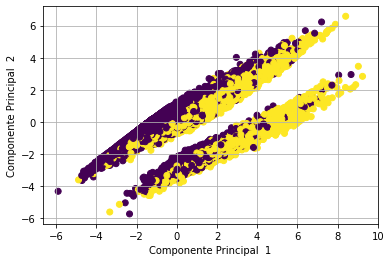

In [74]:
scatter_plot_pca = plt.figure().add_subplot(1,1,1) 

scatter_plot_pca.scatter(x=pca_df_type_P['principal_component_1'],y=pca_df_type_P['principal_component_2'],c=pca_df_type_P['target'])
scatter_plot_pca.set_xlabel('Componente Principal  1')
scatter_plot_pca.set_ylabel('Componente Principal  2')
scatter_plot_pca.grid()

plt.show()

In [75]:
pca.explained_variance_ratio_

array([0.51896075, 0.29604798])

En el dataset tenemos únicamente tres variables relacionadas con los pagos de los clientes y en caso de existir una correlación marcada entre las mismas seria visibles tanto en los datos como en el grafico anteriormente expuesto. 

Sin embargo, tanto al observar el grafico como la varianza máxima de aproximadamente 0.52 concluimos que la correlación entre variables no es lo suficientemente fuerte como para realizar una reducción de dimensionalidad para dichas variables por lo cual se conservan sin alteración en el dataset total.

In [76]:
df_pca = pd.concat( [df_pca ,df_reducido_dummies.loc[:,columns[2]]], axis = 1)

#### Variables relacionadas a los gastos (Tipo S)

In [77]:
x = df_reducido_dummies.loc[:,columns[1]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [78]:
pca = PCA(n_components=15)
x_transformada = pca.fit_transform(x)

In [79]:
sum(pca.explained_variance_ratio_)

0.9138205889819414

In [80]:
pca.explained_variance_ratio_

array([0.17311963, 0.10663096, 0.07812148, 0.06664916, 0.06257506,
       0.05671638, 0.04821325, 0.04641299, 0.04558999, 0.04402757,
       0.04239725, 0.04134632, 0.03668547, 0.03481043, 0.03052465])

En el caso de las variables del tipo s poseemos 21 columnas, de las cuales se puede representar aproximadamente un 91 % de su información con 15 componentes principales. Dicha cantidad de componentes se obtuvo al comparar los resultados obtenidos al utilizar distintas cantidades, por ejemplo al utilizar 10 componentes se obtiene un 73% o mediante el uso de 14 componentes obtuvimos un 88%. Con estos resultados consideramos que es mejor utilizar n_components = 15.

Al mismo tiempo, analizamos el aporte de información realizado por cada componente y dado a que ningún valor es inferior a 0.03 (3%) decidimos consérvalos a todos ellos, destacando que existe una mayor cantidad de información contenida en las 2 primeras componentes principales..


In [81]:
columns_s = create_colum_names(15 , 'S_') 
pca_df_aux_type_S = pd.DataFrame(data = x_transformada, columns = columns_s)

In [82]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_S] ,axis = 1)

#### Variables relacionadas a los riesgos (Tipo R)

In [83]:
x = df_reducido_dummies.loc[:,columns[4]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [84]:
pca = PCA(n_components=17)
x_transformada = pca.fit_transform(x)

In [85]:
sum(pca.explained_variance_ratio_)

0.8806814504240108

In [86]:
pca.explained_variance_ratio_

array([0.19247039, 0.07184423, 0.06679876, 0.05440825, 0.05089943,
       0.04777686, 0.0392156 , 0.03892342, 0.03852623, 0.03837657,
       0.03796886, 0.03725737, 0.03556413, 0.03394117, 0.03287575,
       0.03229384, 0.03154059])

En el caso de las variables del tipo R poseemos 26 columnas, de las cuales podemos obtener reultados porcentuales de información que para las columnas del tipo S utilizando 17 componentes principales. Al igual que en el caso anterior se optó por dicha cantidad de componentes principales al comparar los resultados modificando dicho parámetro. 

Al igual que para el caso anterior se toma como criterio que cada componente principal debe aportar un mínimo de 3% de información.



In [87]:
columns_R = create_colum_names(17 ,'R_')
pca_df_aux_type_R = pd.DataFrame(data = x_transformada, columns = columns_R)

In [88]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_R] ,axis = 1)

#### Variables relacionadas a los balances (Tipo B)

In [89]:
x = df_reducido_dummies.loc[:,columns[3]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [90]:
pca = PCA(n_components=13)
x_transformada = pca.fit_transform(x)

In [91]:
sum(pca.explained_variance_ratio_)

0.796764097069967

In [92]:
pca.explained_variance_ratio_

array([0.33340947, 0.11112364, 0.04869113, 0.04210543, 0.03682092,
       0.03411325, 0.0293731 , 0.02809557, 0.02733172, 0.02689613,
       0.02681196, 0.02611281, 0.02587895])

En el caso de las variables del tipo B poseemos 37 columnas y utilizando 13 componentes principales se logra representar aproximadamente el 80% de su información. El análisis realizado es similar al desarrollado anteriormente para las variables de distintos tipos, sin embargo en esta ocasión observamos que únicamente una componente principal almacena aproximadamente el 33% de la información permitiendo así una gran representación de los datos con una cantidad muy reducida de variables respecto al punto de partida.


In [93]:
columns_B = create_colum_names(13 ,'B_')
pca_df_aux_type_B = pd.DataFrame(data = x_transformada, columns = columns_B)

In [94]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_B] ,axis = 1)

#### Variables relacionadas a la delincuencia (Tipo D)

In [95]:
x = df_reducido_dummies.loc[:,columns[0]].values
y = df_reducido_dummies.loc[:,['target']].values

x = StandardScaler().fit_transform(x)

In [96]:
pca = PCA(n_components=34)
x_transformada = pca.fit_transform(x)

In [97]:
sum(pca.explained_variance_ratio_)

0.7965173980568634

In [98]:
pca.explained_variance_ratio_

array([0.12296001, 0.07127817, 0.05529734, 0.04350324, 0.04148382,
       0.03428334, 0.03098462, 0.02932621, 0.02575632, 0.02173536,
       0.02104446, 0.01826108, 0.01688033, 0.01579199, 0.01542573,
       0.014473  , 0.01427027, 0.01394842, 0.01287711, 0.01279809,
       0.01268232, 0.01256676, 0.01253069, 0.0124672 , 0.01239051,
       0.01223014, 0.01208561, 0.01181449, 0.01158377, 0.01138898,
       0.01102816, 0.01066315, 0.01038582, 0.01032087])

Por ultimo tenemos las variables del tipo D relacionadas a la delincuencia, tras los procedimientos realizados sobre el dataset redujimos la cantidad de variables a 80. Sin embargo, observamos que tenemos la posibilidad de obtener aproximadamente el 80% de la información que contienen mediante el uso de 34 componentes principales. Los resultados obtenidos muestran que existen componentes principales que únicamente aportan un 1% de información y pese a ello optamos conservarlos a fin de tener una mayor representación de los datos.


In [99]:
columns_D = create_colum_names(34 ,'D_')
pca_df_aux_type_D = pd.DataFrame(data = x_transformada, columns = columns_D)

In [100]:
df_pca = pd.concat( [df_pca , pca_df_aux_type_D] ,axis = 1)

In [101]:
df_pca = pd.concat( [df_pca , df_reducido['target']] ,axis = 1)

#### Conclusiones

Como resultado de la reducción de dimensionalidad mediante el método de PCA, obtuvimos un dataset de 83 columnas donde para los distintos tipos de variables se procuró conservar aproximadamente un mínimo del 80% de la información. Considerando que previo al procedimiento el dataset contaba con 168 columnas, concluimos que es beneficiosa la aplicación de la reducción de dimensionalidad con el fin de obtener una mejor performance en los distintos modelos que utilicen como fuente de información dicho dataset modificado.

In [102]:
df_pca

,P_2,P_3,P_4,S_1,S_2,S_3,S_4,S_5,S_6,S_7,...,D_26,D_27,D_28,D_29,D_30,D_31,D_32,D_33,D_34,target
0,0.868580,0.689886,0.007455,-2.898584,0.085358,0.767740,-0.560084,0.664197,-0.561271,-0.853606,...,-0.287183,0.177329,0.316125,-1.753930,-0.480730,-0.820786,0.201346,-0.317601,1.046728,0
1,0.414444,0.557492,0.957622,0.935086,-0.965246,-0.538334,1.703724,0.620479,0.010761,0.816514,...,0.376701,-0.149022,0.152258,0.179575,-0.005567,-0.241059,0.072231,0.111100,0.197566,0
2,0.408131,0.608540,0.008573,0.464833,0.871602,-0.936698,-0.434236,-0.189318,0.119886,-0.957924,...,0.534821,0.334504,0.032404,-0.111631,0.304494,0.820281,-0.183966,-0.724470,-0.570341,1
3,0.359892,0.374767,0.009922,1.198177,0.617719,-1.038145,-0.238809,-0.368435,0.346914,-0.093333,...,-1.003179,-3.137114,1.080425,-1.779528,4.251674,2.585711,-0.049884,2.116991,0.795107,1
4,0.311111,0.512139,0.963224,1.008087,-1.656863,-0.452177,2.843438,1.001564,-0.295520,0.400813,...,0.549876,0.169676,-0.041207,0.430994,-0.571204,-0.636162,0.097009,-0.192456,0.124503,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276567,0.703939,0.619083,0.004705,2.229533,0.880567,0.060648,-0.412833,-0.168784,0.282989,-0.101462,...,-0.275261,-0.282711,0.574025,-0.429842,-0.496315,0.077999,-0.383687,-0.199867,-1.112053,0
276568,0.895553,0.786104,0.008739,-1.003391,0.344174,-0.390606,-0.009446,0.164462,0.428303,0.207067,...,-0.117193,-1.292950,-0.317442,3.040307,-0.790639,2.437747,2.051753,-2.777274,0.415983,0
276569,0.780039,0.627228,0.006754,-2.001636,0.417368,0.044487,-0.279186,0.766529,0.195224,-0.180456,...,0.294102,0.151897,-0.173116,1.272966,0.902547,-1.126424,-2.663873,0.490347,0.263348,0
276570,0.794548,0.625673,0.001326,-2.270228,0.670521,-0.059370,-0.160369,0.236371,-0.548114,-0.490292,...,-0.030244,0.047514,-0.024415,0.451348,0.778730,-0.440808,-2.282502,0.060832,0.150955,0


In [103]:
df_pca.to_parquet("gdrive/My Drive/train_data_apc")

### Balance del dataset

A continuación observamos el desbalance que presenta nuestro dataset en relación a la variable de estudio “target”, aproximadamente los casos en los que los clientes si pagan sus cuentas son tres veces más que aquellos que no, representando un 75% de los usuarios estudiados. Consideramos que dicho desbalance es una situación que representa de forma correcta a nuestro problema de estudio.

Luego dividimos nuestro conjunto de datos, distribuyendo de forma balanceada los elementos de la variable target. En dicha distribución se utiliza un 30% de la información para el conjunto de datos de prueba y un 70% para el conjunto de entrenamiento. De esta forma obtuvimos dos conjuntos de datos representado un 30% y un 70% de los datos y respetando la proporción de casos de la variable target.


In [113]:
df_pca['target'].value_counts()

0    207712
1     68860
Name: target, dtype: int64

In [114]:
from sklearn.model_selection import train_test_split

features = df_pca.columns.to_list()
features.remove('target')

x_train, x_test, y_train, y_test = train_test_split(df_pca[features].values, df_pca['target'].values, test_size=0.3, random_state=0, stratify = df_pca['target'].values)

### Normalización de valores

Teniendo en cuenta los modelos que se emplearan más adelante en el trabajo y a fin de mejorar su rendimiento procedemos a normalizar nuestro dataset. Podemos utilizar este procedimiento sobre todas las columnas del dataset gracias a que el trabajo anteriormente realizado sobre el mismo nos asegura que los valores que contiene no son un impedimento. 

In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)